In [1145]:
import pandas  as pd
import numpy  as np
import matplotlib.pyplot as plt
import csv
import random as r
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
class Patient:
    def __init__(self,id: int, features : list[float], label : int ) -> None:
        self.id = id
        self.features = features #[Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal]
        self.label = label
    
    def __str__(self) -> str:
        print(f"id:{self.id},features:{self.features} label:{self.label}")
def sanitize_data(raw,labels): #2d to 3d
    indexlabel = np.unique(labels)
    
    fixed_data = [[] for _ in range(len(indexlabel))]
    fixed_label = [[] for _ in range(len(indexlabel))]
    for i in range(len(labels)):
        fixed_data[labels[i]].append(raw[i])
        fixed_label[labels[i]].append(labels[i])
    return fixed_data, fixed_label

### Read data from csv ; Convert into `features` and `label`


In [1146]:
def fetchdata(filename):
        with open(filename, newline = '') as csvfile:
                chestpain = {"nontypical" : 3, "nonanginal" : 2, "asymptomatic" : 1, "typical" : 0,"NA":0}
                thal = {"normal" :0, "reversable": 1, "fixed" :2,"NA":0}
                ahd = {"Yes":1,"No":0}

                all_labels = []
                all_features = []

                reader = csv.reader(csvfile, delimiter=',', quotechar='"')
                # data = []
                count = 0
                for row in reader:
                        count+=1
                        if(count == 1) : pass
                        else:
                                index = (row[0])
                                label = ((ahd[row[14]]))
                                features  = (row[0:14])
                                if((features[11] == 'NA') or (features [2] == 'NA') or (features [12] == 'NA')) : continue
                                features[0] = 1
                                features[3] = chestpain[features[3]]
                                features[13] = thal[features[13]]
                                features = np.asarray(features,dtype=float)

                                all_features.append(features)
                                all_labels.append(label)
                                # data.append(Patient(index,features,label))
        return all_features,all_labels

all_features, all_labels = fetchdata('Heart.csv') #2D and 1D
train_features_old,test_features_old,old_train_labels, old_test_labels = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)
# 2D                    2D              1D              1D
# print(len(train_features_old),len(old_train_labels),len(test_features_old),len(old_test_labels))
sample_train_data = [[2,3],[4,7],[9,11],[5,8]]
sample_train_labels = [0,0,1,1]

In [1147]:
class LogisticRegression:        
    def sigmoid(z): 
        return 1 / (1 + np.exp(-z))
    def loss(y, y_hat):
        loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
        return loss
    def gradients(data, y, y_hat):
        num_points = data.shape[0] # num_points-> number of training examples.
        dw = (1/num_points)*np.dot(data.T, (y_hat - y))      
        return dw
    def normalize(X): #return list ;without nan
        num_points, n = np.matrix(X).shape
        for _ in range(n):
            with np.errstate(divide='ignore', invalid='ignore'):
                X = (X - X.mean(axis=0))/X.std(axis=0)
        X = np.nan_to_num(X,nan = 1)
        return (X).tolist()
    def train_LR(train_data,train_labels,alpha = 0.002, max_iter = 1000, debug = False):
        Train_data = np.array(train_data)                               ## num_points*n = datapoint*features*n
        normalized_data = LogisticRegression.normalize(Train_data)      # num_points*n = datapoint*features

        num_points = len(normalized_data)                                #no. of data points
        n = len(normalized_data[0])                                      # no. of features
        slope = (([0.69 for _ in range(n)]))                            ## 1 * features ;randomly intialize slope == {b0, b1 ...}
        count = 0
        while(count < max_iter):
            slope = (np.matrix(slope).T)
            y_hat_all = (np.dot(slope.T,np.matrix(np.matrix(normalized_data).T)).tolist())[0]
            y_hats = [0 for _ in range(num_points)]
            for i in range(0,num_points):
                y_hats[i] = LogisticRegression.sigmoid(y_hat_all[i])

            error = (np.matrix(y_hats) - np.matrix(train_labels)).tolist() # 1*num_points

            p = (np.dot(np.matrix(error).T,np.matrix(normalized_data[i])))
            sumed = np.sum(p,axis=0)
            sumed_list = (sumed.tolist())

            change = (alpha/num_points)*np.array(sumed_list)
            slope = (slope).T
            slope -= change
            slope = slope.tolist()[0]
            count+=1
        return slope
    def finding_accuracy(confidence_list,testing_labels, threshold,debug = False):
        j=1
        predicted_labels = [j := 0 if i < threshold else 1 for i in confidence_list]
        ratio = (sum([1 for i in range(len(predicted_labels)) if predicted_labels[i] == testing_labels[i]]))/len(predicted_labels) , 
        if(debug == True) : return ratio
        accuracy = max([(sum([1 for i in range(len(predicted_labels)) if predicted_labels[i] == testing_labels[i]]))/len(predicted_labels) , 
                    (sum([1 for i in range(len(predicted_labels)) if predicted_labels[i] != testing_labels[i]]))/len(predicted_labels)])
        
        return accuracy
    def test_LR(test_data, test_labels, slope,threshold = 0.5,debug = False):
        test_data = LogisticRegression.normalize(np.array(test_data))   #converting test_data in same form
        x = (np.dot(np.matrix(slope),np.matrix(test_data).T)).tolist()[0]
        prob = [LogisticRegression.sigmoid(i) for i in x]

        accuracy = LogisticRegression.finding_accuracy(prob,test_labels,threshold,debug=False)
        return accuracy, prob
    def Logistic_Regression(train_features,train_labels,test_features,test_labels,accuracy_only=True,debug = False):
        slope = LogisticRegression.train_LR(train_features,train_labels)
        accuracy, prob_list = LogisticRegression.test_LR(test_features,test_labels,slope)
        if(accuracy_only) : return accuracy
        return prob_list , accuracy

In [1148]:
class FDA:
    def calc_means(data,debug = False):
        ar = (np.array(data))
        means = []
        means_feature_wise = []
        for i in ar:
            i = np.array(i)
            rows,columns = i.shape
            means.append([np.array(np.mean(i, axis=0)) for _ in range(rows)])
            means_feature_wise.append(np.array(np.mean(i, axis=0)))
        if(debug == True):
             print("calc_means\n")
             print("array data\n",ar)
             print("rows and col",rows,columns)
             print("Means: ",means)
             print(means_feature_wise)
        return means, means_feature_wise
    def calc_Sjs(data,means,debug = False):
         features_number = (len(data[0][0]))
         Sw = [[0 for _ in range(features_number)] for _ in range(features_number)]
         count = 0
         for i in data:
            number_of_data = len(i)
            i = np.array(i).T
            mi = np.array(means[count]).T
            # rows,columns = i.shape
          
            single = (np.dot(i-mi,(i-mi).T))
            ith_sj = single/(number_of_data-1)
            Sw += (ith_sj)
            count+=1
         if(debug == True):
            print("calc_Sj\n")
            print(number_of_data-1)
            print("array data\n",data)
            print("array means\n",means)
            print("list of Sw\n",Sw)
         return Sw
    def FDA(data, labels, n_components=1):
        train_features_old = data
        old_train_labels = labels
        train_features, train_labels = sanitize_data(train_features_old,old_train_labels)
        m ,mean_of_features = (FDA.calc_means(train_features))
        sj = [0,0]
        class0, class1 = train_features[0], train_features[1]
        num_class0,num_class1 = len(class0),len(class1)
        u = np.matrix(mean_of_features[0] - mean_of_features[1])

        for i in range(len(train_features)): # classes = 2
            r,c = np.matrix(train_features[i]).shape         ## train_features == 2*(datpoints*(1*14)))
            for j in range(r):
                x = np.matrix(train_features[i][j]-mean_of_features[i]).T ## 1*14
                sj[i] += np.dot(x,x.T) #14*14

        sj[0] , sj[1] = np.multiply(num_class0,sj[0]) , np.multiply(num_class1,sj[1])
        S = (np.matrix(sj[0] + sj[1])) # 14*14
        S[0][0][np.isclose(S[0][0], 0.0, atol=1e-6)] = 1e-6
        Sinv = np.linalg.inv(S) # 14*14
        w = (np.dot(Sinv,u.T))
        return w
    def project(data_features,w):
        projected_data = (np.dot(w.T,np.matrix(data_features).T)).tolist()[0]
        return projected_data

sample_train_data = [[2,3],[4,7],[9,11],[5,8],]
sample_train_labels = [0,0,1,1]
w = FDA.FDA(sample_train_data,sample_train_labels,n_components=1)
train_features = FDA.project(sample_train_data,w)  #num_data*1 ##1D
test_features = FDA.project(sample_train_data,w)    #num_data*1 ##1D

# train_features = [[i] for i in train_features]
# test_features = [[i] for i in train_features]
# FDAaccuracy = LogisticRegression.Logistic_Regression(train_features,sample_train_labels, test_features,sample_train_labels)
# print(f"""Accuracy with preprocessing with FCA and classification by Logistic Regression = {FDAaccuracy}\n""")
print(w)

[[-0.1]
 [-0.1]]


In [1149]:
LRaccuracy = LogisticRegression.Logistic_Regression(train_features_old,old_train_labels,test_features_old,old_test_labels)
print(f"""\nAccuracy with without preprocessing and classification by Logistic Regression = {LRaccuracy}\n""")


Accuracy with without preprocessing and classification by Logistic Regression = 0.7



# Applying FDA as preprocessing

In [1150]:
w = FDA.FDA(train_features_old,old_train_labels,n_components=1)
train_features = FDA.project(train_features_old,w)  #num_data*1 ##1D
test_features = FDA.project(test_features_old,w)    #num_data*1 ##1D
train_features = [[i] for i in train_features]
test_features = [[i] for i in test_features]
FDAaccuracy = LogisticRegression.Logistic_Regression(train_features,old_train_labels, test_features,old_test_labels)
print(f"""Accuracy with preprocessing with FCA and classification by Logistic Regression = {FDAaccuracy}\n""")

Accuracy with preprocessing with FCA and classification by Logistic Regression = 0.8333333333333334



### Applying inbuilt PCA, reducing into lesser features

In [1151]:
pca = PCA(n_components=9)
pca.fit(train_features_old)
train_features_PCA = pca.transform(train_features_old)
test_features_PCA = pca.transform(test_features_old)

# Applying FDA on PCA processed data as preprocessing

In [1152]:
w = FDA.FDA(train_features_PCA,old_train_labels,n_components=1)
train_features = FDA.project(train_features_PCA,w)  #num_data*1 ##1D
test_features = FDA.project(test_features_PCA,w)    #num_data*1 ##1D
train_features = [[i] for i in train_features]
test_features = [[i] for i in test_features]
PCAFRAaccuracy = LogisticRegression.Logistic_Regression(train_features,old_train_labels, test_features,old_test_labels)
print(f"""Accuracy with preprocessing with PCA then FCA and classification by Logistic Regression = {PCAFRAaccuracy}""")

Accuracy with preprocessing with PCA then FCA and classification by Logistic Regression = 0.8833333333333333


Accuracy with PCA reduction to 12 features then FCA then classify by Logistic Regression = 0.8166666666666667
Accuracy with PCA reduction to 11 features then FCA then classify by Logistic Regression = 0.8333333333333334
Accuracy with PCA reduction to 10 features then FCA then classify by Logistic Regression = 0.8833333333333333
Accuracy with PCA reduction to 9 features then FCA then classify by Logistic Regression = 0.8833333333333333
Accuracy with PCA reduction to 8 features then FCA then classify by Logistic Regression = 0.8166666666666667
Accuracy with PCA reduction to 7 features then FCA then classify by Logistic Regression = 0.85
Accuracy with PCA reduction to 6 features then FCA then classify by Logistic Regression = 0.8333333333333334
Accuracy with PCA reduction to 5 features then FCA then classify by Logistic Regression = 0.8333333333333334
Accuracy with PCA reduction to 4 features then FCA then classify by Logistic Regression = 0.7
Accuracy with PCA reduction to 3 features the

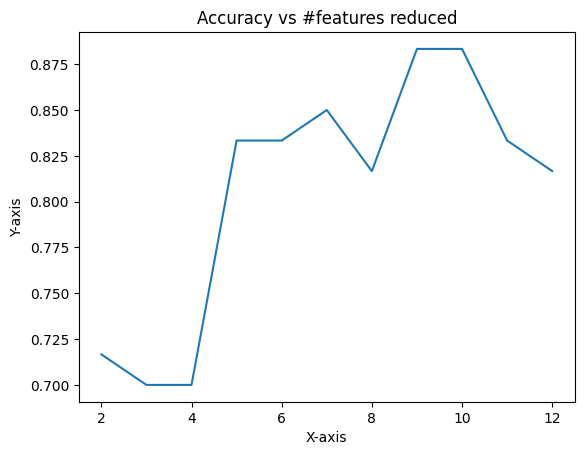

In [1153]:
acc = []
f = []
for i in range(12,1,-1):
    f.append(i)
    pca = PCA(i)
    pca.fit(train_features_old)
    train_features_PCA = pca.transform(train_features_old)
    test_features_PCA = pca.transform(test_features_old)

    w = FDA.FDA(train_features_PCA,old_train_labels,n_components=1)
    train_features = FDA.project(train_features_PCA,w)  #num_data*1 ##1D
    test_features = FDA.project(test_features_PCA,w)    #num_data*1 ##1D
    train_features = [[i] for i in train_features]
    test_features = [[i] for i in test_features]
    PCAFRAaccuracy = LogisticRegression.Logistic_Regression(train_features,old_train_labels, test_features,old_test_labels)
    print(f"""Accuracy with PCA reduction to {i} features then FCA then classify by Logistic Regression = {PCAFRAaccuracy}""")
    acc.append(PCAFRAaccuracy)
plt.plot(f,acc)
plt.title('Accuracy vs #features reduced')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()


## Applying FDA on PCA processed data v/s Applying FDA only ; then logistic regression 
The accuracy on `PCA+FDA` depends amount on features reduction on the `PCA` step, more the feature the reduction more after the "sweet" stop as the PCA will give data with much less variance <br />
Example:- PCA reduction to 1around 8 features gives "best" accuracy rest lesser the features reduced by PCA reduced accuracy till accuracy of only LR is reached (by fetures reduced to 2)